# Advanced trajectory inference and characterization with CellRank

## Data

<div style="padding-top: 10px; font-size: 15px;">We'll start from the previously saved AnnData of metacells that we called <code>2_TrajectoriesAdata.h5ad</code>

<div style="padding-top: 10px; font-size: 15px;">If you didn't manage to save it, you can copy it in your fodlers from the shared one. Open a terminal and copy this command (changing the path to the shared folder):

```
rsync <PATH/TO/SHARED/FOLDER>/2_TrajectoriesAdata.h5ad $HOME/BrainOmics2024/2_Day2
```
## Notebook content

<div style="padding-top: 10px; font-size: 20px;">
Cellrank Overview:
</div>

<div>
  <img src="https://cellrank.readthedocs.io/en/latest/_images/100_cellrank_overview.png" width="800">
</div>

<div>
  <p>
    <strong>Reference:</strong> 
    <a href="https://www.nature.com/articles/s41592-024-02303-9">CellRank 2: unified fate mapping in multiview single-cell data</a>
  </p>
</div>



<div style="padding-top: 10px; font-size: 15px;">
    <p>
        Cellrank allows to easily convert directed (e.g., pseudotime) and/or undirected (static transcriptional similarity) neighbor graphs into <strong>cell–cell transition matrices</strong>.<br>
        Cell–cell transition matrices derived from diverse modalities can be combined to model the cells' relationships and their hierarchies.<br><br>
        The obtained model can be used to:<br>
        <ul>
            <li>Compute Macrostates </li>
            <li>Compute fate probabilities</li>
            <li>Perform other downstream tasks</li>
        </ul>
    </p>
</div>

To get started you can have a look at this <a href="https://cellrank.readthedocs.io/en/latest/notebooks/tutorials/general/100_getting_started.html">Tutorial</a>

<div class="alert alert-block alert-info">
  <b>NOTE: Here we will use CellRank capabilities to:</b>
  
  * Refine the trajectories obtained from the previous notebook <a href="./2_Palantir.ipynb"> (2_Palantir.ipynb)</a>
    *  Combining **Palantir pseudotime**, to **transcriptional similarity** and **Pluripotency score**
  * Formalize fate probabilities
  * Compute putative lineage-drive genes

# Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import cellrank as cr
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "jupyterlab"
import random
random.seed(1)


In [2]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Load Metacells anndata

In [3]:
n_neighb = 30
n_pcs = 5

In [4]:
CombinedAdata = sc.read_h5ad("./2_TrajectoriesAdata.h5ad")

# 1 **CytoTRACE** for potency score computation

<div>
  <img src="https://cytotrace.stanford.edu/CytoTRACEframework2.png" width="800">
</div>


<div>
  <p>
    <strong>Reference:</strong> 
    <a href="https://www.science.org/doi/10.1126/science.aax0249">Single-cell transcriptional diversity is a hallmark of developmental potential</a>
  </p>
</div>

<div style="padding-top: 10px; font-size: 15px;">We will now use one of the kernels proposed by CellRank to compute a potency score that will be later combined with Palantir pseudotime to increase the accuracy of the inferred trajectories.
    
<div style="padding-top: 10px; font-size: 15px;">
    <p>
        CytoTRACE relies on the assumption that:<br> 
        <ul>
            <li>Cells expressing <strong>more genes</strong> are likely <strong>less differentiated</strong> </li>
            <li>Less differentiated cells <strong>must be present</strong> in the analysed SC dataset</li>
        </ul>
    </p>
</div>

In [5]:
from cellrank.kernels import ConnectivityKernel
from cellrank.kernels import CytoTRACEKernel
from cellrank.kernels import PseudotimeKernel

#Cytotrace
adataCR = CombinedAdata.copy()

adataRaw = adataCR.copy()
adataRaw.X = adataRaw.layers["median"].copy()

adataCR.raw = adataRaw.copy()

<div style="padding-top: 10px; font-size: 15px;">
CytoTRACE needs a transition matrix to calculate the score of differentiation potential. We use use <code>scvelo.pp.moments()</code> to compute it for each cell according to its neighbourhood as it will evaluate the numbers of genes expressed in the cells and in its neighbourhood. For this, with single cells we would copy the X matrix in the "spliced" and "unspliced" layers. However, single cell counts are sparse while the metacells are not as sparse anymore by construction. For this reason, we will use the layer storing the median of the counts of each gene in a metacells as it preserve some of the sparsity of the original dataset. 

In [6]:
adataCR.layers["spliced"] = adataCR.layers["median"].copy()
adataCR.layers["unspliced"] = adataCR.layers["median"].copy()

# win n_pcs = None and n_neighnors = None the function will use the parameters already stored in the AnnData
scv.pp.moments(adataCR, n_pcs=None, n_neighbors=None, use_highly_variable=False)

computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


<div style="padding-top: 10px; font-size: 15px;">
We create the CytoTRACE score by running the following command:
</div>

In [7]:
ctk = CytoTRACEKernel(adataCR).compute_cytotrace(use_raw=True).compute_transition_matrix(threshold_scheme="soft", nu=0.5)

  0%|          | 0/3200 [00:00<?, ?cell/s]

<div style="padding-top: 10px; font-size: 15px;">
    
Specifically:

<ul>
    <li><code>CytoTRACEKernel(adataCR)</code>: Initializes the kernel with adataCR as input. </li>
    <li><code>.compute_cytotrace(use_raw=True)</code>: Computes the CytoTRACE scores (differentiation potential) using the data stored in adataCR.raw.</li>
    <li><code>.compute_transition_matrix(threshold_scheme="soft", nu=0.5)</code>: Computes a transition matrix, which reflects the probabilities of cells transitioning from one state to another. The threshold_scheme="soft" and nu=0.5 are parameters that affect how the transition probabilities are scaled or normalized. For more info, have a look at the <a href="https://cellrank.readthedocs.io/en/latest/api/_autosummary/kernels/cellrank.kernels.CytoTRACEKernel.html#compute-transition-matrix">API</a>. </li>
</ul>

We can compare the results of CytoTRACE and Palantir:
</div>

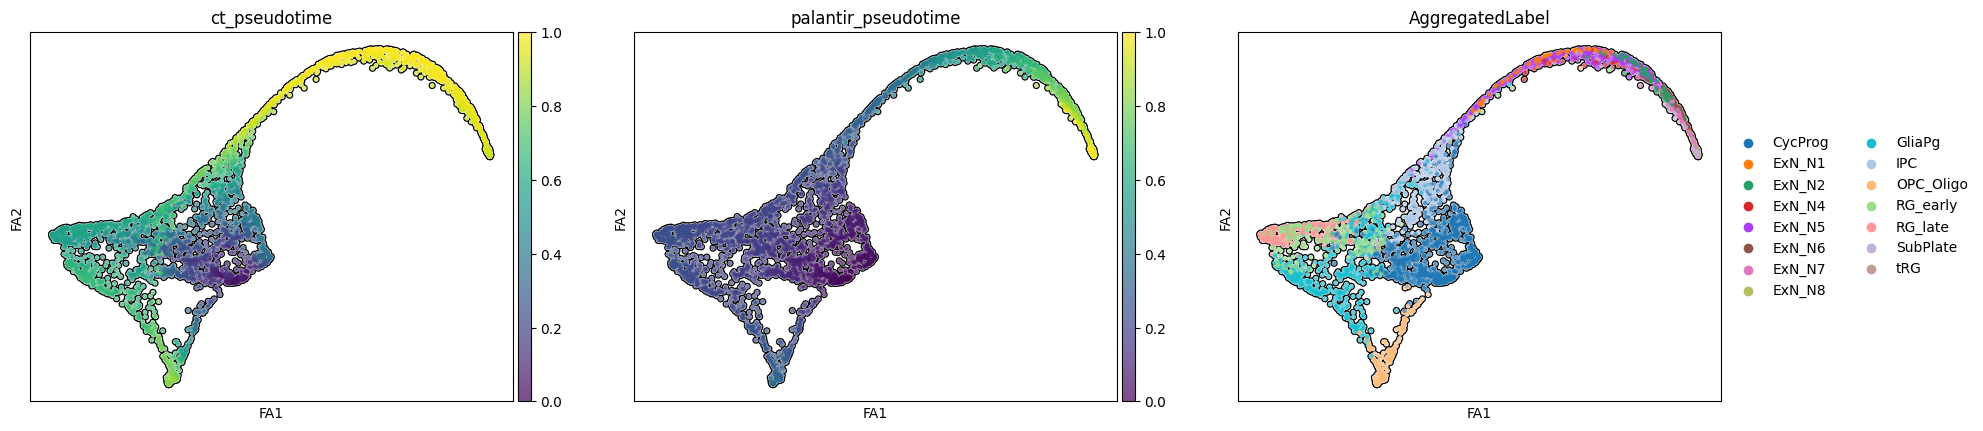

In [8]:
sc.pl.draw_graph(adataCR, color=["ct_pseudotime","palantir_pseudotime","AggregatedLabel"], add_outline=True)

## 1.2 CytoTRACE and Palantir combination 

<div style="padding-top: 10px; font-size: 15px;">
We now combine the following scores by summing them up after scaling their contribution by a certain weight:

<ul>
<li> <b>CytoTRACE</b> output  <span style="color: #ff6347;"><b><i>(CTK)</b></i></span></li>
<li> already available <b>Palantir pseudotime</b> from previous notebook <span style="color: #566ce8;"><b><i>(PK)</b></i></span></li>
<li> <b>transcriptional similarity</b> <span style="color: #1ed42d;"><b><i>(CK)</b></i></span></li>
</ul>
</div>

In [9]:
# connectivities
ck = ConnectivityKernel(adataCR).compute_transition_matrix()

# dpt
pk = PseudotimeKernel(adataCR, time_key="palantir_pseudotime").compute_transition_matrix()

combined_kernel = .8 * pk + .2 * ctk + .1 * ck 
combined_kernel

  0%|          | 0/3200 [00:00<?, ?cell/s]

(0.8 * PseudotimeKernel[n=3200, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * CytoTRACEKernel[n=3200, dnorm=False, scheme='soft', b=10.0, nu=0.5] + 0.1 * ConnectivityKernel[n=3200, dnorm=True, key='connectivities'])

# 2. Macrostate estimation

<div style="padding-top: 10px; font-size: 15px;">
Finally we use GPCCA (Generalized Perron Cluster Cluster Analysis) estimator to compute macrostates and cell-cell dynamics from the <b>combined_kernel</b>. Specifically, this estimator will output a soft classification of cells to macrostates and a transition matrix of those. For more information, have a look at the <a href="https://cellrank.readthedocs.io/en/latest/api/_autosummary/estimators/cellrank.estimators.GPCCA.html#cellrank.estimators.GPCCA">API</a>

In [10]:
from cellrank.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[kernel=(0.727 * PseudotimeKernel[n=3200] + 0.182 * CytoTRACEKernel[n=3200] + 0.091 * ConnectivityKernel[n=3200]), initial_states=None, terminal_states=None]


<div style="padding-top: 10px; font-size: 15px;">
Since we are giving a `cluster_key` names and colors of the states will be associated with the existing clusters:

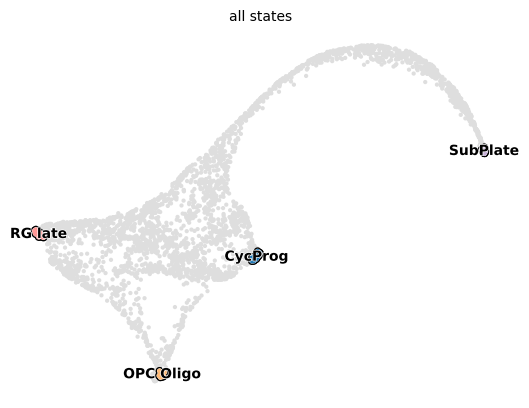

In [11]:
g.fit(n_states=4, cluster_key="AggregatedLabel")
g.plot_macrostates(which="all", basis="X_draw_graph_fa")

<div style="padding-top: 10px; font-size: 15px;">
Here we <span style="color: #ff6347;">manually</span> assign initial and terminal states from the detected macrostates

  0%|          | 0/3 [00:00<?, ?/s]

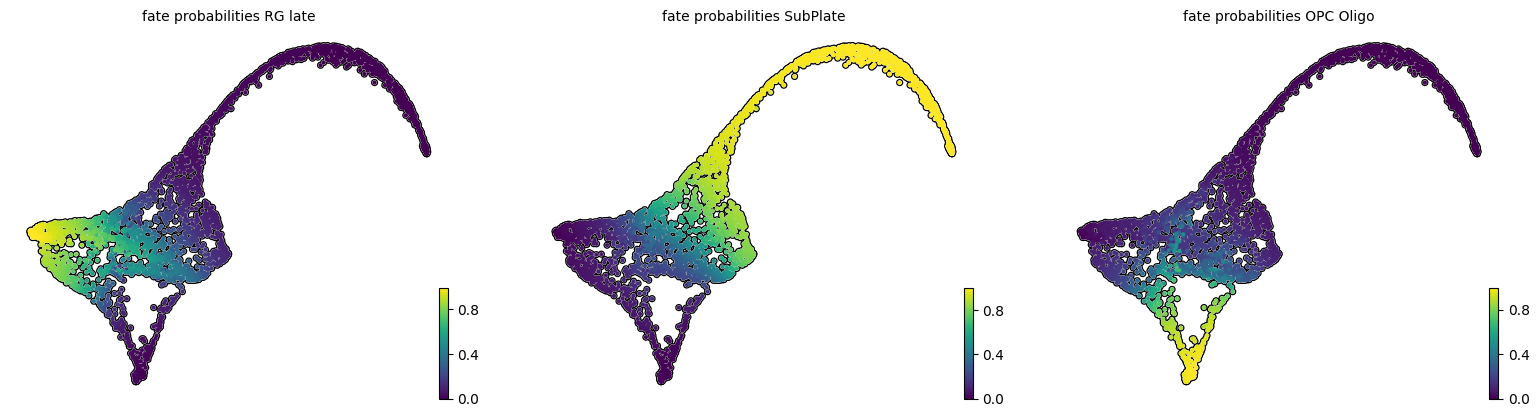

In [12]:
g.set_initial_states("CycProg")
g.set_terminal_states(["RG_late", "SubPlate","OPC_Oligo"])
g.compute_fate_probabilities()
g.plot_fate_probabilities(basis="X_draw_graph_fa", same_plot=False, add_outline=True)

In [13]:
["RG_late", "SubPlate","OPC_Oligo"]

['RG_late', 'SubPlate', 'OPC_Oligo']

# 3. Computation of **lineage drivers**

<div style="padding-top: 10px; font-size: 15px;">
Lineage driver genes are obtained by <span style="color: #ff6347;">correlating</span> the fate probabilities with gene expression with gene-expression through `compute_lineage_drivers()` function

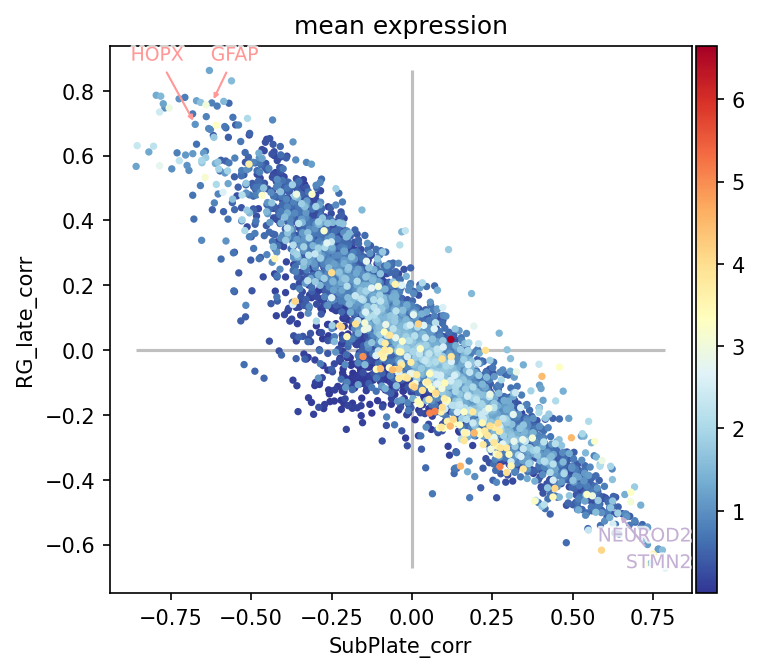

In [14]:
# compute driver genes
driver_df = g.compute_lineage_drivers()

# define set of genes to annotate
SubPlate_genes = ["STMN2", "NEUROD2"]
RG_late_genes = ["GFAP", "HOPX"]



genes_oi = {
    "SubPlate": SubPlate_genes,
    "RG_late": RG_late_genes,
}

# make sure all of these exist in AnnData
assert [
    gene in adataCR.var_names for genes in genes_oi.values() for gene in genes
], "Did not find all genes"

adataCR.var["mean expression"] = adataCR.X.A.mean(axis=0)


# visualize in a scatter plot
g.plot_lineage_drivers_correlation(
    lineage_x="SubPlate",
    lineage_y="RG_late",
    adjust_text=True,
    gene_sets=genes_oi,
    color="mean expression",
    legend_loc="none",
    figsize=(5, 5),
    dpi=150,
    fontsize=9,
    size=50,
)

<div style="padding-top: 10px; font-size: 15px;">
We can obtain gene expression trends for each main trajectory by weighting each cells by its fate probability fitting a Generalized Additive Model (GAM). For more information on this you can have a look at the <a href="https://www.nature.com/articles/s41592-024-02303-9">API</a>

In [15]:
model = cr.models.GAMR(adataCR, n_knots=6, smoothing_penalty=10.0)

  0%|          | 0/40 [00:00<?, ?gene/s]

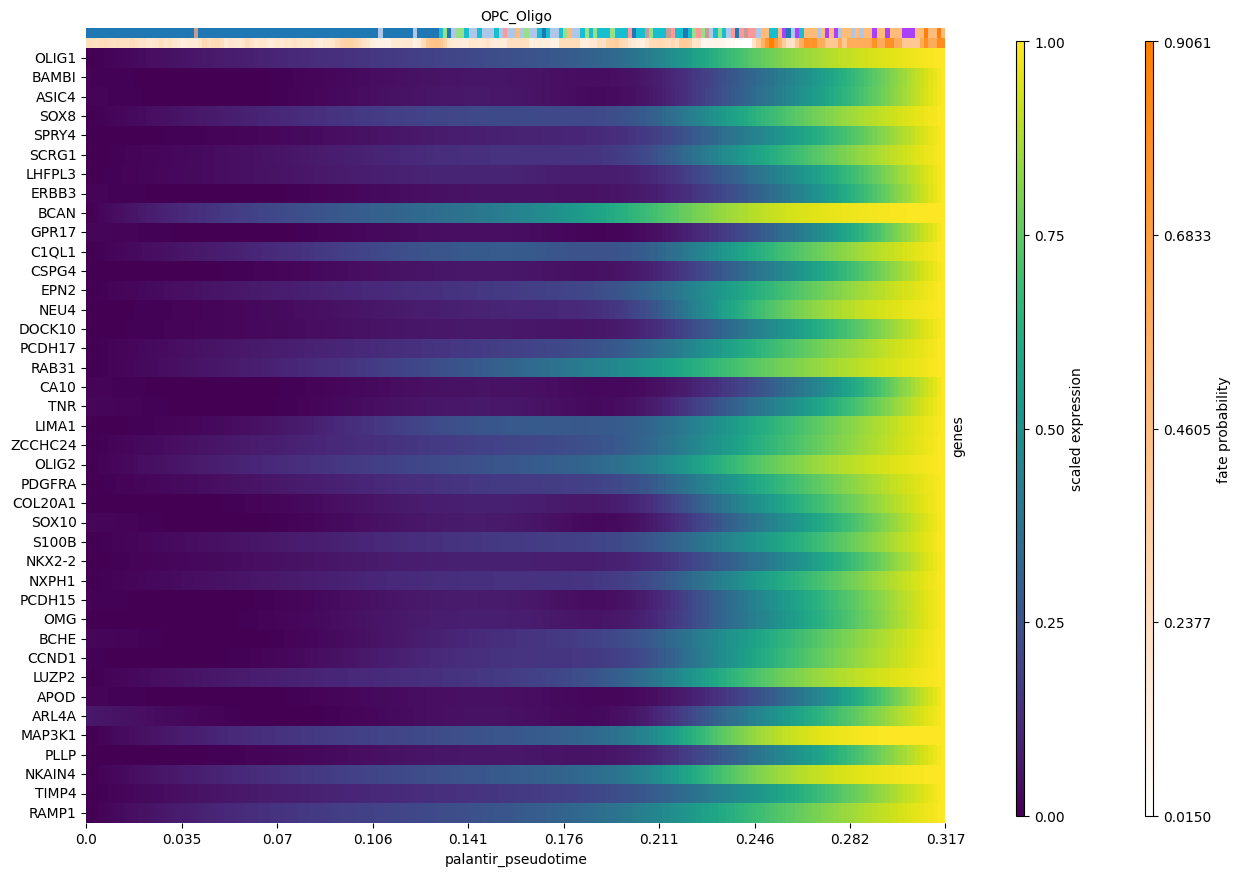

In [16]:
# compute putative drivers for the Beta trajectory
OPC_Oligo_drivers = g.compute_lineage_drivers(lineages="OPC_Oligo")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="OPC_Oligo",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=OPC_Oligo_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

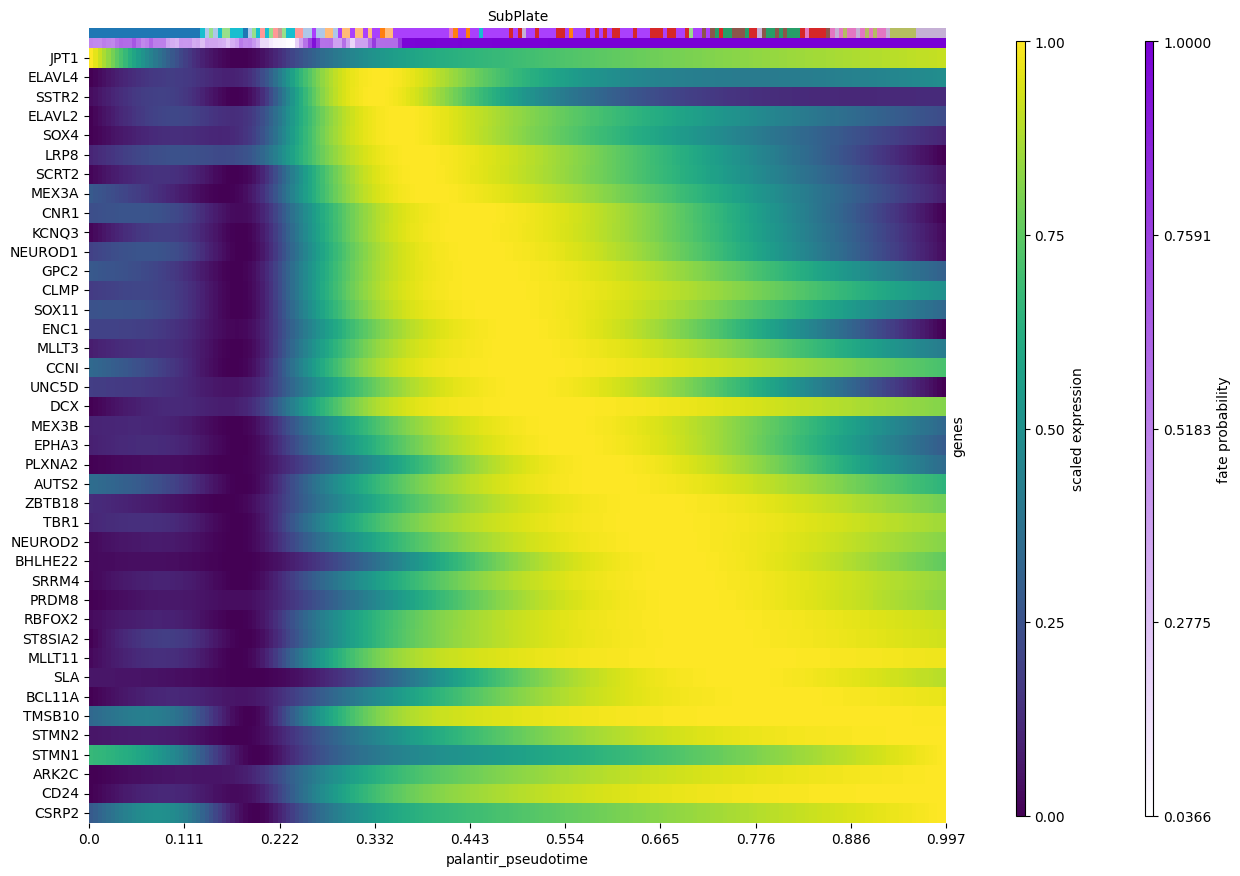

In [17]:
# compute putative drivers for the Beta trajectory
SubPlate_drivers = g.compute_lineage_drivers(lineages="SubPlate")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="SubPlate",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=SubPlate_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

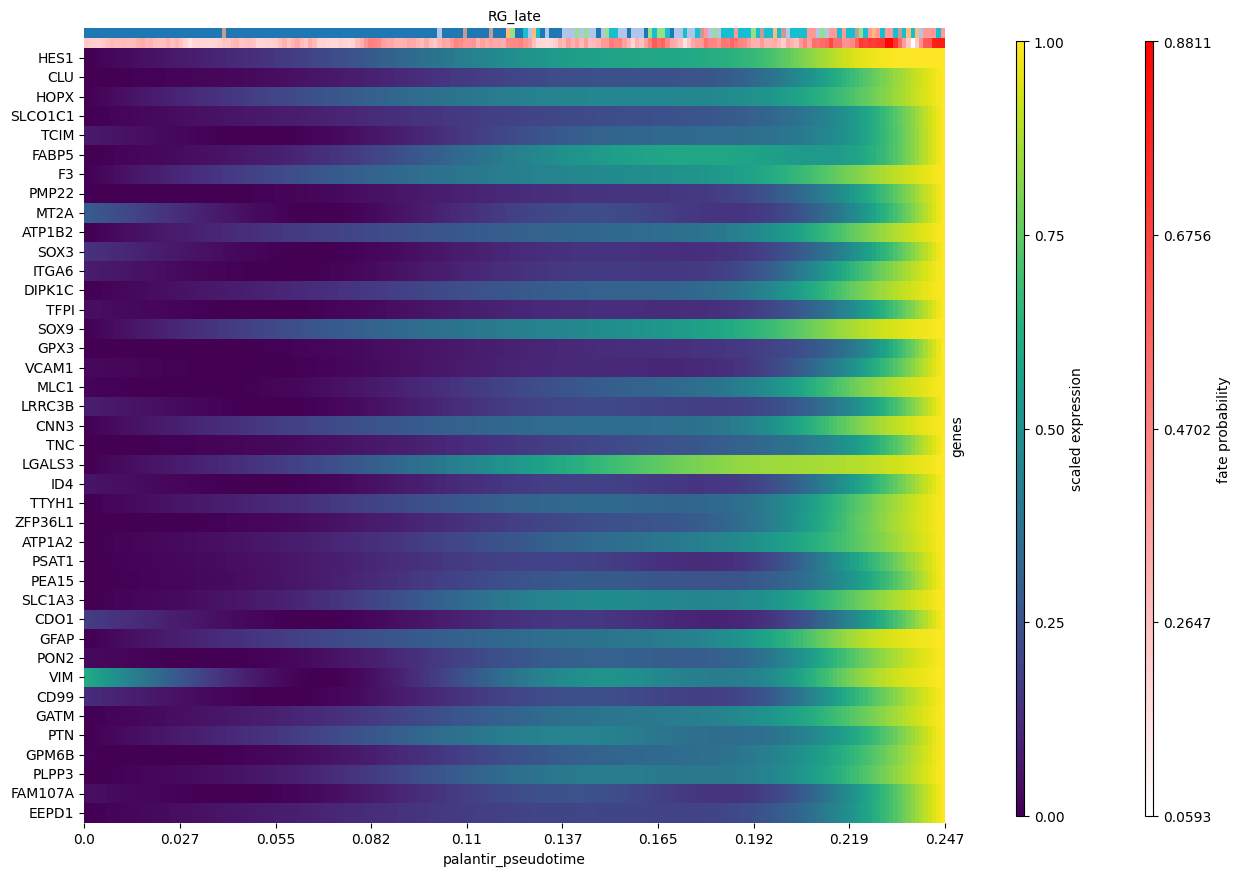

In [18]:
# compute putative drivers for the Beta trajectory
RG_late_drivers = g.compute_lineage_drivers(lineages="RG_late")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="RG_late",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=RG_late_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

# Save

In [19]:
# Save the estimator
g.write("./GPCCA.pickle")

In [20]:
# Save anndata
adataCR.write_h5ad("./3_CellrankAdata.h5ad")